Resampling methods involves repeatedly drawing samples from a training set and refitting a model on each sample to obtain additional information about the fitted model. Because resampling involves fitting the same statistical method multiple times using different subsets of the training data, it can be computationally expensive.
The process of evaluating a model's performance is known as _model assessment_, where as the process of selecting the proper level of flexibility for a model is known as _model selection_.


### Cross-Validation
The _test error_ rate is the average error that results from using a statistical learning method to predict the response on a new observation. A suitable statistical learning method should result in a low test error rate. In contrast, the _training error_ can be calculated by applying the statistical learning method to the observations used in its training. Typically, the training error rate will be much lower than the training error rate.

#### Validation Set Approach
The validation set approach, involves randomly dividing the available set of observations into two parts, a _training set_ and _a validation set (or hold-out set)_. The model is fit on the training set and the fitted model is used to predict the response for observations in the validation set. The error rate for the validation set provides an estimate of the test error rate.

In [1]:
import sklearn.linear_model as skl_lm
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('./Auto.csv', na_values='?').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 29.1+ KB


For non-linear relationships higher order polynomial fit might provide better results than using only linear terms. One way to identify whether higher order polynomials affect the target is to use the p-values associated with the higher order polynomial terms.

We can also the validation method to see whether higher degree polynomials results in better results. We can randomly split the 392 observations into two sets. We can plot the validation set error rates resulting from fitting various regression models on the training sample and evaluating their performance on the validation sample.

In [4]:
horsepower = df['horsepower'].values
mpg = df['mpg'].values

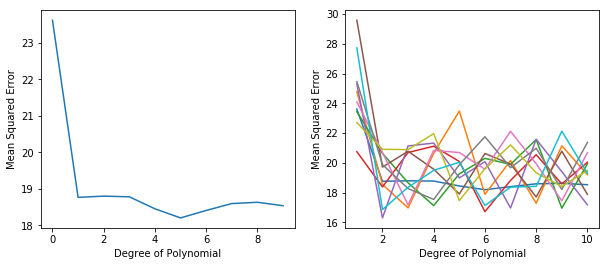

In [5]:
p_order = np.arange(1,11)
rsplits = np.arange(10)

mean_error = np.zeros((10,10))
regr = skl_lm.LinearRegression()

for rsplit in rsplits:
    for p in p_order:
    # Create a features matrix polynomials upto the given degrees 
        X = PolynomialFeatures(p).fit_transform(X=horsepower.reshape((-1,1)))
    # Split data to random training and test sets
        X_train, X_test, y_train, y_test= train_test_split(X, mpg, test_size =0.5,random_state =rsplit*p)
    
    # Fit Model using training data    
        model = regr.fit(X_train, y_train)
    # Prediction 
        predict = model.predict(X_test)
    # Calculate the mean squared error
        mse = mean_squared_error(y_test, predict)
        mean_error[rsplit,p-1] = mse

# Plot figure
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))        

# Plot MSE for the first train/test split for polynormial functions of horsepower
ax1.plot(mean_error[0])

# Plot MSE for 10 random train/test splits
for rsplit in rsplits:
    ax2.plot(p_order,mean_error[rsplit])
    
for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_xlabel('Degree of Polynomial')

All ten curves indicate that model with a quadratic term has a smaller validation set MSE than a model with only a linear term. Furthermore, there is not much benefit in including cubic or higher-order polynomial terms in the model. Each of the ten train/validation sets results in different MSE estimates.

#### Drawbacks of validation set approach
1. Validation set estimate of the test error rate can be highly variable, depending on which observations are included in the training set and which observations are included in the validation set.
2. Since only a subset of the observations (those in the training set) is used to fit the model, the model will tend to perform worse than model fitted on the entire data set.

### Leave One Out Cross Validation
Leave one out cross validation (LOO CV) attempts to address the drawbacks of validation set approach. LOOCV involves splitting the set of observations into two parts. Rather than creating two comparable size subsets, LOO approach uses a single observation $(x_1, y_1)$ as the validation set, and remaining observations ${(x_2, y_2),...,(x_n, y_n)}$ make up training set. The statistical model is fitted on the $n-1$ observations in the training set, and the remaining observation is used to make the prediction $\hat y_1$.
The MSE for the observation $(x_1, y_1)$ provides an unbiased estimate for the test error. Since the MSE is based on a single observation $(x_1, y_1)$ is highly variable.

We can repeat the procedure by using $(x_2, y_2)$ as the validation set and the remaining n-1 observation to fit the model. We can repeat this approach n times, each time keeping one observation as the test set and using the remainder as the training set, to product n squared errors $MSE_1,...,MSE_n$. The LOOCV estimate for the test MSE is the average of these n estimates.
$$CV = \frac{1}{n}\sum_i^n MSE_i$$

One of advantages of LOOCV is that it has far less bia since we repeatdly fit the model with a training set containing n-1 observations, whereas in validation set approach we would use only around half the original data set. Consequently, the LOOCV approach tends not to overestimate the test error. Additionally, since the train, test split does not involve any randomness, the LOOCV will always give the same results.

Since the model has to be fitted _n_ times, LOOCV can be expensive to implement.

### _k_-Fold Cross Validation
k-fold CV involves randomly dividing the set of observations into _k_ groups, or folds, approximately of equal size. The first fold is treated as the validation set and the model is fitted on the remaining k-1 folds. The mean squared error is computed on the observations in the validation set. We will repeat the process k times, each time keeping a fold as the validation set and using the remaining k-1 folds as the training set. This results in k estimates for the test error $MSE1, MSE2,..., MSE3$. The k-fold CV estimate can be computed by averaging the MSE values.
$$CV = \frac{1}{k}\sum^k_i MSE_i$$

LOOCV is a special case of k-fold CV where k equals to n. Typically k-fold CV is performed using k=5 or k=10. Performing LOOCV may be computationally expensive, especially if n is extreamly large, since the model has to be fitted n times. In contrast 10-fold CV only requires the model to be fitted 10 times.

In [6]:
loo = LeaveOneOut()
p_order = np.arange(1,11)
loo_mse = np.zeros_like(p_order,dtype=float)

for i,order in enumerate(p_order):
    X = PolynomialFeatures(order).fit_transform(horsepower.reshape((-1,1)))

    mean_error = []
    for train_index, test_index in loo.split(X):
        model = regr.fit(X[train_index],mpg[train_index])
        predict = model.predict(X[test_index])

        mse = mean_squared_error(mpg[test_index], predict)
        mean_error.append(mse)
    
    loo_mse[i] = np.mean(mean_error)

In [7]:
iteration = 9
folds = 10
p_order = np.arange(1,11)

cv_score = np.zeros((9,10))

# Perform CV for 9 different instances
for i in range(iteration):
    # Calculate CV score for each degree of polynomial
    for p,order in enumerate(p_order):
        X = PolynomialFeatures(order).fit_transform(horsepower.reshape((-1,1)))
        fold_mse = []
    # Perform CV
        kfold = KFold(n_splits= 10,shuffle=True)
        for fold, (train_index , test_index ) in enumerate(kfold.split(X)):
            model = regr.fit(X[train_index],mpg[train_index])
            predict = model.predict(X[test_index])

            fold_mse.append(mean_squared_error(mpg[test_index], predict))
    # Calculate CV score
        cv_score[i,p] = np.mean(fold_mse)    

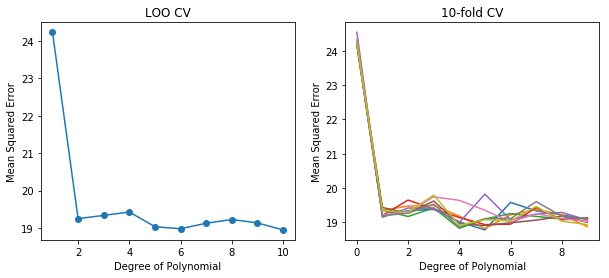

In [8]:
fig , (ax1, ax2) = plt.subplots(1,2, figsize =(10,4))

ax1.plot(p_order, loo_mse, '-o')
ax1.set_title('LOO CV')

for i in cv_score:
    ax2.plot(i)
    ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_xlabel('Degree of Polynomial')
    ax.set_ylabel('Mean Squared Error')

#### Bias- Variance Trade-Off for k-Fold Cross Validation
Validation set approach can lead to overestimates of the test error rate, since this only half the dataset is used to fit the model. LOOCV will give approximately unbiased estimates for the test error, since each training set contains _n-1_ observations. k-fold CV on the other hand will lead to an intermediate level of bias, since each training set contains fewer observations than in the LOOCV approach. 

When we perform LOOCV, we are in effect averaging outputs of _n_ fitted models, each of which is trained on an almost identical set of observations, there for these outputs are highly correlated with each other. This results in a high variance in the test error estimate obtained by the LOOCV approach. In contrast, when we perform _k_-fold CV we are averaging the output of _k_ fitted models that are somewhat less than correlated with each other since the overlap between the training sets in each model is smaller. Thus, the test error estimate resulting from k-fold CV tends to have a lower variance than the test error estimate resulting from LOOCV.

Given these consideration k-fold cross validation does not result in either execessivly high bias or from very high variance.

**Variance of test error estimate for LOOCV and k-fold CV**

In [6]:
loo = LeaveOneOut()
p_order = np.arange(1,11)
loo_mse = np.zeros_like(p_order,dtype=float)

for i,order in enumerate(p_order):
    X = PolynomialFeatures(order).fit_transform(horsepower.reshape((-1,1)))

    mean_error = []
    for train_index, test_index in loo.split(X):
        model = regr.fit(X[train_index],mpg[train_index])
        predict = model.predict(X[test_index])

        mse = mean_squared_error(mpg[test_index], predict)
        mean_error.append(mse)
    
    loo_mse[i] = np.var(mean_error)

In [7]:
iteration = 9
folds = 10
p_order = np.arange(1,11)

cv_score = np.zeros((9,10))

# Perform CV for 9 different instances
for i in range(iteration):
    # Calculate CV score for each degree of polynomial
    for p,order in enumerate(p_order):
        X = PolynomialFeatures(order).fit_transform(horsepower.reshape((-1,1)))
        fold_mse = []
    # Perform CV
        kfold = KFold(n_splits= 10,shuffle=True)
        for fold, (train_index , test_index ) in enumerate(kfold.split(X)):
            model = regr.fit(X[train_index],mpg[train_index])
            predict = model.predict(X[test_index])

            fold_mse.append(mean_squared_error(mpg[test_index], predict))
    # Calculate CV score
        cv_score[i,p] = np.var(fold_mse)  

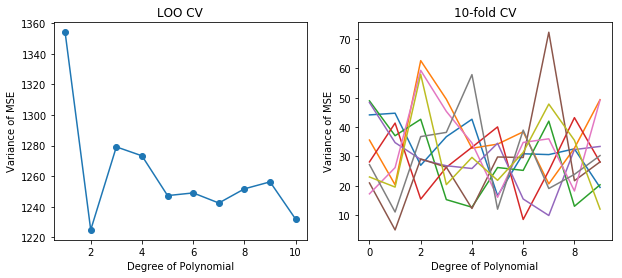

In [9]:
fig , (ax1, ax2) = plt.subplots(1,2, figsize =(10,4))

ax1.plot(p_order, loo_mse, '-o')
ax1.set_title('LOO CV')

for i in cv_score:
    ax2.plot(i)
    ax2.set_title('10-fold CV')

for ax in fig.axes:
    ax.set_xlabel('Degree of Polynomial')
    ax.set_ylabel('Variance of MSE')